In [88]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [111]:
df=pd.read_csv('data/crop_production.csv')

In [112]:
df.head(5) 

,index,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,0,AUS,CROPYIELD,RICE,TONNE_HA,A,1990,8.314607,NaN
1,1,AUS,CROPYIELD,RICE,TONNE_HA,A,1991,8.394737,NaN
2,2,AUS,CROPYIELD,RICE,TONNE_HA,A,1992,8.094340,NaN
3,3,AUS,CROPYIELD,RICE,TONNE_HA,A,1993,8.336000,NaN
4,4,AUS,CROPYIELD,RICE,TONNE_HA,A,1994,8.537815,NaN


In [113]:
new_data=df.drop(['index', 'INDICATOR', 'MEASURE', 'FREQUENCY','Flag Codes'], axis=1)

In [114]:
new_data

,LOCATION,SUBJECT,TIME,Value
0,AUS,RICE,1990,8.314607
1,AUS,RICE,1991,8.394737
2,AUS,RICE,1992,8.094340
3,AUS,RICE,1993,8.336000
4,AUS,RICE,1994,8.537815
...,...,...,...,...
20561,OECD,SOYBEAN,2021,37010.208830
20562,OECD,SOYBEAN,2022,37069.214850
20563,OECD,SOYBEAN,2023,37143.459750
20564,OECD,SOYBEAN,2024,37013.651900


In [115]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20566 entries, 0 to 20565
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LOCATION  20566 non-null  object 
 1   SUBJECT   20566 non-null  object 
 2   TIME      20566 non-null  int64  
 3   Value     20566 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 642.8+ KB


In [116]:
new_data.isnull().sum()

LOCATION    0
SUBJECT     0
TIME        0
Value       0
dtype: int64

<Axes: >

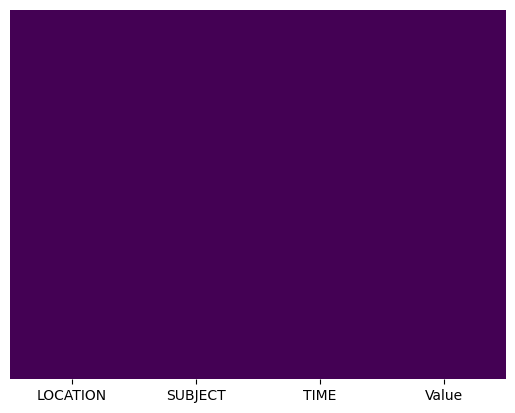

In [117]:
sns.heatmap(data=new_data.isnull(), cbar=False, yticklabels=False, cmap='viridis')

This shows no missing data

#### Standard scaling the data

In [45]:
#scaler=MinMaxScaler(feature_range=(0,1))

### Scaling Time and Value

In [46]:
#Scaled_data=scaler.fit_transform(new_data[['TIME', 'Value']])

In [48]:
# Create a DataFrame for scaled data
#scaled_df = pd.DataFrame(Scaled_data, columns=['Scaled_TIME', 'Scaled_Value'])

In [49]:
# Combine original and scaled data
#combined_df = pd.concat([new_data, scaled_df], axis=1)

In [50]:
#combined_df.head()

In [51]:
# data_new
#data_new_actual=combined_df.drop(columns=['TIME', 'Value'], axis=1)

In [52]:
#data_new_actual.head()

### Perparing X and y

In [118]:
X=new_data.drop(columns='Value', axis=1)

In [119]:
X

,LOCATION,SUBJECT,TIME
0,AUS,RICE,1990
1,AUS,RICE,1991
2,AUS,RICE,1992
3,AUS,RICE,1993
4,AUS,RICE,1994
...,...,...,...
20561,OECD,SOYBEAN,2021
20562,OECD,SOYBEAN,2022
20563,OECD,SOYBEAN,2023
20564,OECD,SOYBEAN,2024


In [120]:
y=new_data['Value']

In [121]:
y

0            8.314607
1            8.394737
2            8.094340
3            8.336000
4            8.537815
             ...     
20561    37010.208830
20562    37069.214850
20563    37143.459750
20564    37013.651900
20565    37041.401580
Name: Value, Length: 20566, dtype: float64

In [122]:
# representing y in a dataframe
y=pd.DataFrame(y)

In [123]:
y

,Value
0,8.314607
1,8.394737
2,8.094340
3,8.336000
4,8.537815
...,...
20561,37010.208830
20562,37069.214850
20563,37143.459750
20564,37013.651900


### SEPERATING NUMERICAL FEATURES FROM CATEGORICAL FEATURES

This is to create a pipeline for transforming cat features and numeric features

In [124]:
num_features=X.select_dtypes(exclude="object").columns
cat_features=X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

cat_transformer= OneHotEncoder()
numeric_transformer=MinMaxScaler(feature_range=(0,1))
scaling_y=MinMaxScaler(feature_range=(0,1))
y=scaling_y.fit_transform(y)

preprocessor=ColumnTransformer(
    [
        ("OneHotEncoder", cat_transformer, cat_features),
        ("Minmaxscaler", numeric_transformer, num_features),
    ]
)



In [125]:
X=preprocessor.fit_transform(X)

In [126]:
X.shape

(20566, 53)

In [127]:
X

<20566x53 sparse matrix of type '<class 'numpy.float64'>'
	with 61697 stored elements in Compressed Sparse Row format>

In [128]:
y

array([[7.25504810e-06],
       [7.32496695e-06],
       [7.06285037e-06],
       ...,
       [3.24101422e-02],
       [3.22968762e-02],
       [3.23210897e-02]])

In [129]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [137]:
y_train

array([[3.01432093e-07],
       [4.07449899e-05],
       [3.04990578e-07],
       ...,
       [1.49165260e-04],
       [4.18949029e-06],
       [2.27860601e-06]])

In [63]:
#y_train_np=y_train.values.reshape(-1,1)

In [64]:
#y_test_np=y_test.values.reshape(-1,1)

In [65]:
#y_train_scaled=scaler_y.fit_transform(y_train.values.reshape(-1,1)).flatten()

### Creating Evaluation Metrics 

In [130]:
def evaluate_model(true, predicted):
    mea = mean_absolute_error(true,predicted)
    mse = mean_squared_error(true, predicted)
    r2_square= r2_score(true, predicted)
    rmse=np.sqrt(mean_squared_error(true, predicted))
    return mea, mse, r2_square, rmse


In [138]:
models= {
    "LinearRegression":LinearRegression(),
    "Lasso":Lasso(),
    "Ridge":Ridge(),
    "KNeighborsRegressor":KNeighborsRegressor(),
    "RandomForestRegressor":RandomForestRegressor(),
    "DecisionTreeRegressor":DecisionTreeRegressor(),
    "AdaBoostRegressor":AdaBoostRegressor(),
    "SVR":SVR(),
    "CatBoostRegressor":CatBoostRegressor(),
    "XGBRegressor":XGBRegressor(),
    "GradientBoostRegresor":GradientBoostingRegressor()    
}

model_list=[]
r2_list=[]

for i in range(len(list(models))):
    model=list(models.values())[i]
    #model.fit(X_train, y_train)
    model.fit(X_train, y_train)

    # predicting some y_train and y_test

    y_train_predict=model.predict(X_train)
    y_train_predict_unscaled=scaling_y.inverse_transform(y_train_predict.reshape(-1,1)).flatten()
    y_test_predict=model.predict(X_test)
    y_test_predict_unscaled=scaling_y.inverse_transform(y_test_predict.reshape(-1,1)).flatten()
    
    # evaluate the prediction
    model_train_mse, model_train_mae, model_train_rmse, model_train_r2=evaluate_model(y_train, y_train_predict)
   # model_train_mse, model_train_mae, model_train_rmse, model_train_r2=evaluate_model(y_train.flatten(), y_train_predict_unscaled)

    model_test_mse, model_test_mae, model_test_rmse, model_test_r2=evaluate_model(y_test, y_test_predict)
    #model_test_mse, model_test_mae, model_test_rmse, model_test_r2=evaluate_model(y_test.flatten(), y_test_predict_unscaled)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- Mean squared Error: {:.4f}".format(model_train_mse))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- Mean squared Error: {:.4f}".format(model_train_mse))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

LinearRegression
Model performance for Training set
- Root Mean Squared Error: 0.3849
- Mean Absolute Error: 0.0017
- Mean squared Error: 0.0129
- R2 Score: 0.0410
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3391
- Mean Absolute Error: 0.0017
- Mean squared Error: 0.0129
- R2 Score: 0.0413


Lasso
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0027
- Mean squared Error: 0.0178
- R2 Score: 0.0523
----------------------------------
Model performance for Test set
- Root Mean Squared Error: -0.0000
- Mean Absolute Error: 0.0026
- Mean squared Error: 0.0178
- R2 Score: 0.0508


Ridge
Model performance for Training set
- Root Mean Squared Error: 0.3849
- Mean Absolute Error: 0.0017
- Mean squared Error: 0.0129
- R2 Score: 0.0410
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3392
- Mean Absolute Error: 0.0017
- Mean squared Error: 0.0129
- R2 Score

C:\Users\eMIKE\AppData\Local\Temp\ipykernel_16852\1732817933.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


RandomForestRegressor
Model performance for Training set
- Root Mean Squared Error: 0.5130
- Mean Absolute Error: 0.0013
- Mean squared Error: 0.0091
- R2 Score: 0.0365
----------------------------------
Model performance for Test set
- Root Mean Squared Error: -0.0225
- Mean Absolute Error: 0.0026
- Mean squared Error: 0.0091
- R2 Score: 0.0514


DecisionTreeRegressor
Model performance for Training set
- Root Mean Squared Error: 0.5186
- Mean Absolute Error: 0.0013
- Mean squared Error: 0.0090
- R2 Score: 0.0363
----------------------------------
Model performance for Test set
- Root Mean Squared Error: -0.1947
- Mean Absolute Error: 0.0031
- Mean squared Error: 0.0090
- R2 Score: 0.0555


AdaBoostRegressor
Model performance for Training set
- Root Mean Squared Error: 0.3901
- Mean Absolute Error: 0.0017
- Mean squared Error: 0.0151
- R2 Score: 0.0409
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3668
- Mean Absolute Error: 0.0016
- Mea

c:\Users\eMIKE\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\eMIKE\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR
Model performance for Training set
- Root Mean Squared Error: -1.9907
- Mean Absolute Error: 0.0082
- Mean squared Error: 0.0839
- R2 Score: 0.0905
----------------------------------
Model performance for Test set
- Root Mean Squared Error: -2.1658
- Mean Absolute Error: 0.0082
- Mean squared Error: 0.0839
- R2 Score: 0.0904


Learning rate set to 0.06373
0:	learn: 0.0510269	total: 7.62ms	remaining: 7.61s
1:	learn: 0.0498839	total: 13.3ms	remaining: 6.63s
2:	learn: 0.0489346	total: 19.6ms	remaining: 6.5s
3:	learn: 0.0479832	total: 27.7ms	remaining: 6.89s
4:	learn: 0.0471708	total: 34.3ms	remaining: 6.83s
5:	learn: 0.0463580	total: 40.1ms	remaining: 6.64s
6:	learn: 0.0456266	total: 46.5ms	remaining: 6.59s
7:	learn: 0.0449432	total: 52.4ms	remaining: 6.5s
8:	learn: 0.0443987	total: 57.8ms	remaining: 6.37s
9:	learn: 0.0438692	total: 64.4ms	remaining: 6.38s
10:	learn: 0.0434047	total: 70.6ms	remaining: 6.35s
11:	learn: 0.0430035	total: 76.6ms	remaining: 6.3s
12:	learn: 0.0426459	total:

c:\Users\eMIKE\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostRegresor
Model performance for Training set
- Root Mean Squared Error: 0.4640
- Mean Absolute Error: 0.0015
- Mean squared Error: 0.0106
- R2 Score: 0.0383
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3985
- Mean Absolute Error: 0.0016
- Mean squared Error: 0.0106
- R2 Score: 0.0394




In [140]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
7,SVR,0.090365
5,DecisionTreeRegressor,0.055513
4,RandomForestRegressor,0.051356
1,Lasso,0.050788
9,XGBRegressor,0.048364
8,CatBoostRegressor,0.044306
3,KNeighborsRegressor,0.043019
0,LinearRegression,0.041289
2,Ridge,0.041285
6,AdaBoostRegressor,0.040413


The best model is Lasso

In [143]:
y_train.flatten()

array([3.01432093e-07, 4.07449899e-05, 3.04990578e-07, ...,
       1.49165260e-04, 4.18949029e-06, 2.27860601e-06])

In [144]:
SVR_model = SVR()
SVR_model = SVR_model.fit(X_train, y_train)
y_pred = SVR_model.predict(X_test)
y_predict_unscaled=scaling_y.inverse_transform(y_pred.reshape(-1,1)).flatten()
y_test_unscaled=scaling_y.inverse_transform(y_test.reshape(-1,1)).flatten()
score = r2_score(y_test_unscaled, y_predict_unscaled)*100
print(" Accuracy of the model is %.2f" %score)

c:\Users\eMIKE\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Accuracy of the model is -216.58


In [149]:
GB_model = GradientBoostingRegressor()
GB_model = GB_model.fit(X_train, y_train)
y_pred = GB_model.predict(X_test)
y_predict_unscaled=scaling_y.inverse_transform(y_pred.reshape(-1,1)).flatten()
y_test_unscaled=scaling_y.inverse_transform(y_test.reshape(-1,1)).flatten()
score = r2_score(y_test_unscaled, y_predict_unscaled)*100
print(" Accuracy of the model is %.2f" %score)

c:\Users\eMIKE\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Accuracy of the model is 39.85


In [147]:
AdaB_model = AdaBoostRegressor()
AdaB_model = AdaB_model.fit(X_train, y_train)
y_pred = AdaB_model.predict(X_test)
y_predict_unscaled=scaling_y.inverse_transform(y_pred.reshape(-1,1)).flatten()
y_test_unscaled=scaling_y.inverse_transform(y_test.reshape(-1,1)).flatten()
score = r2_score(y_test_unscaled, y_predict_unscaled)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 35.67


c:\Users\eMIKE\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [148]:
DT_model = DecisionTreeRegressor()
DT_model = DT_model.fit(X_train, y_train)
y_pred = DT_model.predict(X_test)
y_predict_unscaled=scaling_y.inverse_transform(y_pred.reshape(-1,1)).flatten()
y_test_unscaled=scaling_y.inverse_transform(y_test.reshape(-1,1)).flatten()
score = r2_score(y_test_unscaled, y_predict_unscaled)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is -19.47


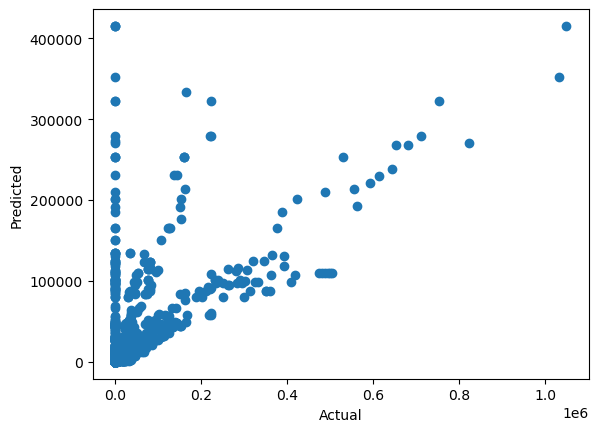

In [150]:
plt.scatter(y_test_unscaled,y_predict_unscaled);
plt.xlabel('Actual');
plt.ylabel('Predicted');

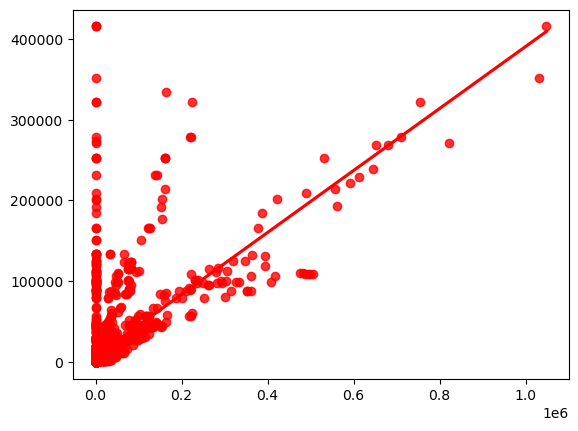

In [151]:
sns.regplot(x=y_test_unscaled,y=y_predict_unscaled,ci=None,color ='red');

In [152]:
pred_df=pd.DataFrame({'Actual Value':y_test_unscaled,'Predicted Value':y_predict_unscaled,'Difference':y_test_unscaled-y_predict_unscaledcon})
pred_df

,Actual Value,Predicted Value,Difference
0,2.237572,1091.898492,-1089.660920
1,1860.100000,1399.543851,460.556149
2,0.808000,3292.867064,-3292.059064
3,5.748374,1204.797758,-1199.049383
4,8.354441,3292.867064,-3284.512623
...,...,...,...
4109,68.000000,-195.020830,263.020830
4110,0.800000,-195.020830,195.820830
4111,2.520000,1047.379089,-1044.859089
4112,1.200000,1223.983004,-1222.783004
